<a href="https://colab.research.google.com/github/BYU-Handwriting-Lab/GettingStarted/blob/solution/notebooks/handwriting-recognition-tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Handwriting Recognition - TensorFlow

This notebook contains code to create a deep learning handwriting recognition
model in TensorFlow. The model is for offline handwritten text using
line-level segmentations. The architecture is a variation from Flor as
described in the following:
* [Handwritten Text Recognition Using TensorFlow 2.0 (Blog Post)](https://medium.com/@arthurflor23/handwritten-text-recognition-using-tensorflow-2-0-f4352b7afe16)
* [Handwritten Text Recognition Using TensorFlow 2.0 (GitHub)](https://github.com/arthurflor23/handwritten-text-recognition)

The model architecture looks very similar to this figure as given in:

[Gated Convolutional Recurrent Neural Networks for Multilingual Handwriting Recognition](https://ieeexplore-ieee-org.erl.lib.byu.edu/document/8270042).

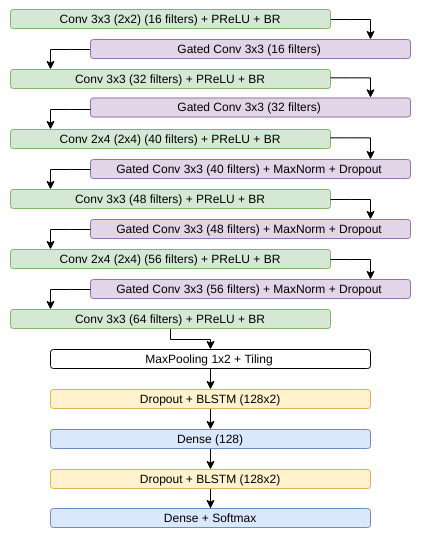

## Imports and Setup

Import the necessary dependencies.

Note that we are using Tensorflow 2 which is substantially different
from Tensorflow 1.

In [1]:
# TensorFlow
import tensorflow as tf
import tensorflow.keras.layers as kl
import tensorflow.keras.constraints as kc

# Data Structures
import pandas as pd
import numpy as np

# Python
import os

# Match
import editdistance as ed

# Image/Plotting
from matplotlib import pyplot as plt
from PIL import Image

# Debugging
from tqdm import tqdm

## Download the Datasets From Google Drive
We will use a very common handwriting recognition dataset called
[IAM](http://www.fki.inf.unibe.ch/databases/iam-handwriting-database).

Download and unzip the dataset from the BYU-Handwriting-Lab Google Drive (courtesy of a clever wget command described [here](https://medium.com/@acpanjan/download-google-drive-files-using-wget-3c2c025a8b99)). In many
instances, we would probably make use of the google.drive API that allows
us to mount our Google drive here in Colab; however, we use this method
because it doesn't require us to authenticate.

A char_set.json file is also downloaded which contains a mapping between
characters and indices.

In [2]:
# IAM Dataset
# ID = 1kF7GhcOAldT-4EReg-s7x8dygb1NnxY9
# FILENAME = iam-line-datasetk.zip
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1kF7GhcOAldT-4EReg-s7x8dygb1NnxY9' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1kF7GhcOAldT-4EReg-s7x8dygb1NnxY9" -O iam-line-dataset.zip && rm -rf /tmp/cookies.txt
!unzip -q iam-line-dataset.zip -d iam
!rm iam-line-dataset.zip

# IAM Pretrained Model Weights
# ID = 1W7AAJw7cmY2jY6WkCj9qqahMPUoMiniB
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1W7AAJw7cmY2jY6WkCj9qqahMPUoMiniB' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1W7AAJw7cmY2jY6WkCj9qqahMPUoMiniB" -O iam_hwr_model.zip && rm -rf /tmp/cookies.txt
!unzip -q iam_hwr_model.zip
!rm iam_hwr_model.zip

Make sure we have the ``iam/`` directory.

In [3]:
!ls

iam  iam_hwr_model  sample_data


## Dataset Mapping Functions

To work with the dataset images in Tensorflow, we need to convert from a file
path to an actual tensor. We can do this with a variety of pre-built Tensorflow
functions and using the standard Tensorflow ```tf.data.Dataset```. The API is
set up with a functional programming flavor utilizing mapping functions. We
show here how to write these mapping functions and load our data into an a
```tf.data.Dataset```.

First we need to define the mapping between characters and integers. To do this
efficiently, we can use a ```tf.lookup.StaticHashTable``` that is very similar
to a normal python dictionary, but is optimized in Tensorflow being able to run
in graph mode.

In [4]:
# The default list of characters used in the recognition model
DEFAULT_CHARS = ' !"#$%&\'()*+,-./0123456789:;=?ABCDEFGHIJKLMNOPQRSTUVWXYZ[]_`abcdefghijklmnopqrstuvwxyz|~£§¨«¬\xad' \
                '°²´·º»¼½¾ÀÂÄÇÈÉÊÔÖÜßàáâäæçèéêëìîïñòóôöøùúûüÿłŒœΓΖΤάήαδεηικλμνξοπρτυχψωόώІ‒–—†‡‰‹›₂₤℔⅓⅔⅕⅖⅗⅘⅙⅚⅛∆∇∫≠□♀♂✓ｆ'

# Turns string of characters into list of characters with indices starting at 1
# We need to retain 0 for the CTC-blank character.
def str_charset_to_lists(charset):
    chars = list(charset)
    indices = list(range(1, len(chars) + 1))
    return chars, indices

# The lookup table to map between characters and integers
def get_char2idx(charset):
    chars, indices = str_charset_to_lists(charset)

    char2idx = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            keys=tf.constant(chars, dtype=tf.string),
            values=tf.constant(indices, dtype=tf.int64)
        ),
        default_value=0,
        name='char2idx_lookup'
    )

    return char2idx

# The lookup table to map between integers and characters
def get_idx2char(charset):
    chars, indices = str_charset_to_lists(charset)

    idx2char = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(
            keys=tf.constant(indices, dtype=tf.int64),
            values=tf.constant(chars, dtype=tf.string)
        ),
        default_value='',
        name='idx2char_lookup'
    )

    return idx2char

We also need a couple functions to pad or truncate our sequences to a standard
length and merge repeating values (as done in CTC-decoding algorithms).

In [5]:
# This is a clever way of padding of truncating sequences with using a loop.
# To run on graph mode, we need to use entirely tf.* functions.
def pad_or_truncate(t, sequence_size=128):
    dim = tf.size(t)
    return tf.cond(tf.equal(dim, sequence_size), lambda: t,
                   lambda: tf.cond(tf.greater(dim, sequence_size), lambda: tf.slice(t, [0], [sequence_size]),
                                   lambda: tf.concat([t, tf.zeros(sequence_size - dim, dtype=tf.int64)], 0)))


# This is a clever way of merging repeating values without using a loop.
# To run on graph mode, we need to use entirely tf.* functions.
def merge_repeating_values(t):
    t2 = tf.roll(tf.pad(t, [[0, 1]], constant_values=-1), -1, 0)[:tf.size(t)]
    not_equal = tf.math.not_equal(t, t2)
    indices = tf.where(not_equal)
    return tf.reshape(tf.gather(t, indices), [-1])

Now that we have Tensorflow lookup tables to go between characters and integers,
we can now create functions to map entire strings or entire batches to their
given character or integer representations. Notice the use of ```tf.map_fn()```.

In [6]:
# Convert a string to its integer tensor representation
def str_to_idxs(string, char2idx, sequence_size):
    idxs = tf.map_fn(lambda char: char2idx.lookup(char), tf.strings.bytes_split(string), dtype=tf.int64)
    return pad_or_truncate(idxs, sequence_size=sequence_size)

# Convert an integer tensor to its character representation
def idxs_to_str(idxs, idx2char, merge_repeated=True):
    if merge_repeated:
        idxs = merge_repeating_values(idxs)

    string = tf.map_fn(lambda idx: idx2char.lookup(idx), idxs, dtype=tf.string)
    string = tf.strings.reduce_join(string)
    return tf.strings.strip(string)

# Convert a batch of strings to its given integer tensor representation
def str_to_idxs_batch(batch, char2idx, sequence_size=128):
    return tf.map_fn(lambda string: str_to_idxs(string, char2idx, sequence_size=sequence_size), batch,
                     dtype=tf.int64)

# Convert a batch of integer tensors to its given string representation 
def idxs_to_str_batch(batch, idx2char, merge_repeated=True):
    return tf.map_fn(lambda idxs: idxs_to_str(idxs, idx2char, merge_repeated=merge_repeated), batch,
                     dtype=tf.string)

Now let's create a function to map image paths to actual tensors. This requires
us to load the images from memory, decode it according to the image format,
normalize the image, perform necessary resizing/padding, and convert to a
tensor format.

In [7]:
def read_and_encode_image(img_path, img_size=(64, 1024)):
    img_bytes = tf.io.read_file(img_path)
    img = tf.image.decode_image(img_bytes, dtype=tf.float32)
    img = tf.image.per_image_standardization(img)
    img = tf.image.resize_with_pad(img, img_size[0], img_size[1])
    img = tf.transpose(img, perm=[1, 0, 2])  # Transpose with channels last

    return img

Now let's combine both the image mapping and character mapping into one
function.

In [8]:
def encode_img_and_transcription(img_path, transcription, char2idx, sequence_size=128, img_size: tuple = (64, 1024)):
    img = read_and_encode_image(img_path, img_size)
    line = str_to_idxs(transcription, char2idx, sequence_size)
    return img, line

Now the final product that will take a tab-delimited CSV file with the contents
resembling | IMG_PATH | TRANSCRIPTION | and produce a ```tf.data.Dataset``` that
will return two tensors representing the image and the transcription.

Example CSV File:

```
./data/image1.png<-TAB->Hello World
./data/image2.png<-TAB->Handwriting Recognition
./data/image3/png<-TAB->Is Cool!
```

In [9]:
def get_encoded_dataset_from_csv(csv_path, char2idx, max_seq_size, img_size):
    path_sep = os.path.sep
    path_prefix = tf.strings.join(csv_path.split('/')[:-1], path_sep)
    return tf.data.experimental.CsvDataset(csv_path, ['img', 'trans'], field_delim='\t', use_quote_delim=False).map(
        lambda img_path, transcription: encode_img_and_transcription(
            tf.strings.join([path_prefix, tf.strings.reduce_join(tf.strings.split(img_path, '/'), separator=path_sep)],
                            separator=path_sep),
            transcription, char2idx, max_seq_size, img_size))

Another handy function to get the size of the dataset. The ```tf.data.Dataset```
class does a terrible job on acquiring the size of the dataset. In many
instances, it's just not possible. We use the pandas library here to get the
total size.

In [10]:
def get_dataset_size(csv_path):
    return len(pd.read_csv(csv_path, sep='\t', header=None, names=['img_path', 'transcription']))

## Model Creation

We can build our actual handwriting recognition model by subclassing the
standard ```tf.keras.Model``` class. We can also subclass other layers like
convolution if it's helpful.

First we create a custom layer called a Gated Convolution. This is used in
the paper [Gated Convolutional Recurrent Neural Networks for Multilingual Handwriting Recognition](https://ieeexplore-ieee-org.erl.lib.byu.edu/document/8270042).

In [11]:
class FullGatedConv2D(kl.Conv2D):
    def __init__(self, filters, **kwargs):
        super(FullGatedConv2D, self).__init__(filters=filters * 2, **kwargs)
        self.nb_filters = filters

    def call(self, inputs):
        output = super(FullGatedConv2D, self).call(inputs)
        linear = kl.Activation("linear")(output[:, :, :, :self.nb_filters])
        sigmoid = kl.Activation("sigmoid")(output[:, :, :, self.nb_filters:])
        return kl.Multiply()([linear, sigmoid])

    def compute_output_shape(self, input_shape):
        output_shape = super(FullGatedConv2D, self).compute_output_shape(input_shape)
        return tuple(output_shape[:3]) + (self.nb_filters,)

    def get_config(self):
        config = super(FullGatedConv2D, self).get_config()
        config['nb_filters'] = self.nb_filters
        del config['filters']
        return config

We now create the recognition model. Notice that we subclass the
tf.keras.Model class.

We create a model that resembles something similar to the architectures
described in:
  * [Gated Convolutional Recurrent Neural Networks for Multilingual Handwriting Recognition](https://ieeexplore-ieee-org.erl.lib.byu.edu/document/8270042)
  * [Are Multidimensional Recurrent Layers Really Necessary for Handwritten Text Recognition?](http://www.jpuigcerver.net/pubs/jpuigcerver_icdar2017.pdf)
  * [Handwritten Text Recognition Using TensorFlow 2.0](https://medium.com/@arthurflor23/handwritten-text-recognition-using-tensorflow-2-0-f4352b7afe16)

In [21]:
class Recognizer(tf.keras.Model):
    def __init__(self, vocabulary_size=197, input_shape=(1, 1024, 64, 1)):
        super(Recognizer, self).__init__(name='flor_recognizer')

        self.conv1 = tf.keras.Sequential(name='conv1')
        self.conv1.add(
            kl.Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), padding="same", kernel_initializer="he_uniform", batch_input_shape=input_shape))
        self.conv1.add(kl.PReLU(shared_axes=[1, 2]))
        self.conv1.add(kl.BatchNormalization(renorm=True))
        self.conv1.add(FullGatedConv2D(filters=16, kernel_size=(3, 3), padding="same"))

        self.conv2 = tf.keras.Sequential(name='conv2')
        self.conv2.add(
            kl.Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding="same", kernel_initializer="he_uniform"))
        self.conv2.add(kl.PReLU(shared_axes=[1, 2]))
        self.conv2.add(kl.BatchNormalization(renorm=True))
        self.conv2.add(FullGatedConv2D(filters=32, kernel_size=(3, 3), padding="same"))

        self.conv3 = tf.keras.Sequential(name='conv3')
        self.conv3.add(
            kl.Conv2D(filters=40, kernel_size=(2, 4), strides=(2, 4), padding="same", kernel_initializer="he_uniform"))
        self.conv3.add(kl.PReLU(shared_axes=[1, 2]))
        self.conv3.add(kl.BatchNormalization(renorm=True))
        self.conv3.add(
            FullGatedConv2D(filters=40, kernel_size=(3, 3), padding="same", kernel_constraint=kc.MaxNorm(4, [0, 1, 2])))
        self.dropout1 = kl.Dropout(rate=0.2, name='dropout1')

        self.conv4 = tf.keras.Sequential(name='conv4')
        self.conv4.add(
            kl.Conv2D(filters=48, kernel_size=(3, 3), strides=(1, 1), padding="same", kernel_initializer="he_uniform"))
        self.conv4.add(kl.PReLU(shared_axes=[1, 2]))
        self.conv4.add(kl.BatchNormalization(renorm=True))
        self.conv4.add(
            FullGatedConv2D(filters=48, kernel_size=(3, 3), padding="same", kernel_constraint=kc.MaxNorm(4, [0, 1, 2])))
        self.dropout2 = kl.Dropout(rate=0.2, name='dropout2')

        self.conv5 = tf.keras.Sequential(name='conv5')
        self.conv5.add(
            kl.Conv2D(filters=56, kernel_size=(2, 4), strides=(2, 4), padding="same", kernel_initializer="he_uniform"))
        self.conv5.add(kl.PReLU(shared_axes=[1, 2]))
        self.conv5.add(kl.BatchNormalization(renorm=True))
        self.conv5.add(
            FullGatedConv2D(filters=56, kernel_size=(3, 3), padding="same", kernel_constraint=kc.MaxNorm(4, [0, 1, 2])))
        self.dropout3 = kl.Dropout(rate=0.2, name='dropout3')

        self.conv6 = tf.keras.Sequential(name='conv6')
        self.conv6.add(
            kl.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", kernel_initializer="he_uniform"))
        self.conv6.add(kl.PReLU(shared_axes=[1, 2]))
        self.conv6.add(kl.BatchNormalization(renorm=True))

        self.mp = kl.MaxPooling2D(pool_size=(1, 2), strides=(1, 2), padding="valid", name='mp')
        self.reshape = kl.Reshape((128, 64), name='reshape')

        self.gru1 = tf.keras.Sequential(name='gru1')
        self.gru1.add(kl.Bidirectional(kl.GRU(units=128, return_sequences=True, dropout=0.5)))
        self.gru1.add(kl.Dense(units=256))
        self.gru1.add(kl.PReLU())

        self.gru2 = tf.keras.Sequential(name='gru2')
        self.gru2.add(kl.Bidirectional(kl.GRU(units=128, return_sequences=True, dropout=0.5)))
        self.gru2.add(kl.Dense(units=vocabulary_size))

    def call(self, x, training=False, visualize_activations=False, **kwargs):
        features = []

        # CNN
        out = self.conv1(x)
        features.append(out)

        if visualize_activations:
            print('conv1')
            display_lines(tf.squeeze(out, 0))
            plt.pause(0.01)

        out = self.conv2(out)
        features.append(out)

        if visualize_activations:
            print('conv2')
            display_lines(tf.squeeze(out, 0))
            plt.pause(0.01)

        out = self.conv3(out)
        features.append(out)

        if visualize_activations:
            print('conv3')
            display_lines(tf.squeeze(out, 0))
            plt.pause(0.01)

        out = self.dropout1(out, training=training)
        out = self.conv4(out)
        features.append(out)

        if visualize_activations:
            print('conv4')
            display_lines(tf.squeeze(out, 0))
            plt.pause(0.01)

        out = self.dropout2(out, training=training)
        out = self.conv5(out)
        features.append(out)

        if visualize_activations:
            print('conv5')
            display_lines(tf.squeeze(out, 0))
            plt.pause(0.01)

        out = self.dropout3(out, training=training)
        out = self.conv6(out)
        features.append(out)

        if visualize_activations:
            print('conv6')
            display_lines(tf.squeeze(out, 0))
            plt.pause(0.01)

        # MaxPool and Reshape
        out = self.mp(out)
        out = self.reshape(out)
        features.append(out)

        if visualize_activations:
            print('reshape')
            display_lines(tf.transpose(out, perm=[2, 0, 1]))
            plt.pause(0.01)

        # print('before')
        # display_lines(tf.transpose(out, perm=[2, 0, 1]))
        # plt.pause(0.01)

        # mask = np.ones(out.shape)
        # mask[:, :, 0:10] = 0.0

        # out = mask * out

        # print('after')
        # display_lines(tf.transpose(out, perm=[2, 0, 1]))
        # plt.pause(0.01)

        # RNN
        out = self.gru1(out)

        if visualize_activations:
            print('reshape')
            display_lines(tf.transpose(out, perm=[2, 0, 1]))
            plt.pause(0.01)

        out = self.gru2(out)

        if visualize_activations:
            print('reshape')
            display_lines(tf.transpose(out, perm=[2, 0, 1]))
            plt.pause(0.01)

        return out, features

In [13]:
def display_lines(feature_map):
    print('Feature Map Shape:', feature_map.shape)

    if len(feature_map.shape) == 3:
        num_features = feature_map.shape[2]

        f, axarr = plt.subplots(num_features, 1, figsize=(20, num_features))
        for i in range(num_features):
            axarr[i].imshow(tf.transpose(feature_map[:, :, i]), cmap='YlGnBu')
    elif len(feature_map.shape) == 2:
        plt.imshow(feature_map, cmap='YlGnBu')
    else:
        raise Exception('Invalid feature map shape:' + str(feature_map.shape))

In [17]:
def confidence(output):
    batch_size = output.shape[0]
    seq_size = output.shape[1]

    values = merge_repeating_values(tf.squeeze(tf.argmax(output, 2)))
    mask = tf.not_equal(values, tf.constant(0, dtype=tf.int64))
    unpadded_label = tf.boolean_mask(values, mask)
    label = tf.expand_dims(pad_or_truncate(unpadded_label, sequence_size=seq_size), 0)
    
    input_lengths = tf.constant(np.full((batch_size), seq_size))
    label_lengths = tf.math.count_nonzero(label, axis=1)

    loss = tf.nn.ctc_loss(label, output, label_lengths, input_lengths, logits_time_major=False)

    probability = tf.exp(-loss)[0].numpy()

    return probability

In [15]:
dataset_iterator = dataset.as_numpy_iterator()

In [16]:
img, label = next(dataset_iterator)
img = tf.expand_dims(img, 0)

(1, 1024, 64, 1)
(1024, 64)


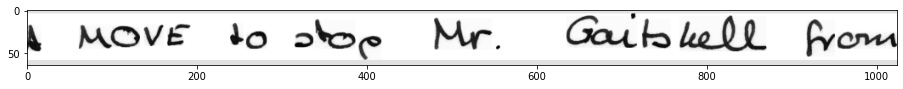

Prediction: b'f MOVE to stop Mr. Gaitskell from'
Confidence: 0.0687


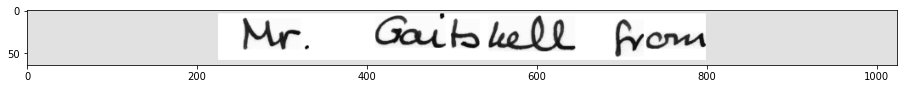

Prediction: b'Mr. Gaitskell from'
Confidence: 0.1656


In [130]:
black = -2.4
img2 = tf.squeeze(img).numpy()

# img2[:, :8] = black
img2 = tf.image.resize_with_pad(tf.expand_dims(tf.expand_dims(img2[450:], 0), 3), 1024, 64)
img2 = tf.squeeze(img2)
print(img.shape)
print(img2.shape)

idx2char = get_idx2char(DEFAULT_CHARS)
model = Recognizer()
model.load_weights('iam_hwr_model/run1')

plt.figure(figsize=(20, 1))
plt.imshow(tf.transpose(tf.squeeze(img)), cmap='gray')
plt.pause(0.01)

output, features1 = model(img, visualize_activations=False)
print('Prediction:', idxs_to_str(tf.squeeze(tf.argmax(output, 2)), idx2char).numpy())
print('Confidence: {:.4f}'.format(confidence(output)))

plt.figure(figsize=(20, 1))
plt.imshow(tf.transpose(tf.squeeze(img2)), cmap='gray')
plt.pause(0.01)

img2 = tf.expand_dims(tf.expand_dims(img2, 0), 3)
output, features2 = model(img2, visualize_activations=False)
print('Prediction:', idxs_to_str(tf.squeeze(tf.argmax(output, 2)), idx2char).numpy())
print('Confidence: {:.4f}'.format(confidence(output)))

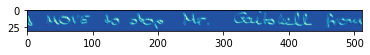

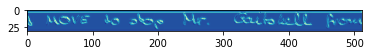

In [114]:
feat1 = tf.squeeze(features1[0])[:, :, 0]
feat2 = tf.squeeze(features2[0])[:, :, 0]

plt.imshow(tf.transpose(feat1), cmap='YlGnBu')
plt.pause(0.01)

plt.imshow(tf.transpose(feat2), cmap='YlGnBu')
plt.pause(0.01)

feat1 = tf.reshape(feat1, [-1])
feat2 = tf.reshape(feat2, [-1])

In [115]:
print(feat1[:10])
print(feat2[:10])

tf.Tensor(
[ 0.09590355  0.27901718  0.13017288  0.02394165  0.02394165  0.02394165
  0.02394165 -0.28079844 -1.1676939  -3.6606507 ], shape=(10,), dtype=float32)
tf.Tensor(
[-2.0993829  -1.3360608  -1.4502832  -2.3117375   0.08579223  0.02394165
  0.02394165 -0.28079844 -1.1676939  -3.6606507 ], shape=(10,), dtype=float32)


In [118]:
(feat1-feat2)[:100]

<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([ 2.1952865 ,  1.615078  ,  1.580456  ,  2.3356793 , -0.06185057,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  1.3200858 ,  0.9158772 ,  1.2294075 ,
        5.060886  ,  0.04596373,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  1.3200858 ,
        0.915877

In [108]:
tf.norm(feat1-feat2, ord='euclidean').numpy() / feat1.shape[0]

0.022147884592413902

Let's run one record through the model just to make sure it works...

Notice the output of the handwriting recognition model
* (Batch, Sequence Length, Character Class)
* Batch: We send multiple images through the model at once. This represents
  each image.
* Sequence Length: The max length of the sequence.
* Character Class: The total number of possible characters the recognition model
  could predict.

If our model isn't trained, it will just give random output. 

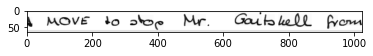

Predicted: tf.Tensor([b'f MOVE to stop Mr. Gaitskell from'], shape=(1,), dtype=string)
Actual: tf.Tensor([b'A MOVE to stop Mr. Gaitskell from'], shape=(1,), dtype=string)


In [23]:
# Define a few constants so we know how to pad our
# transcriptions and resize our images. 
MAX_SEQ_LENGTH = 128
IMG_SIZE = (64, 1024)
VOCABULARY_SIZE = len(DEFAULT_CHARS) + 1  # +1 for CTC-blank character
CSV_PATH = './iam/labels.csv'

# Create the recognition model
model = Recognizer(vocabulary_size=VOCABULARY_SIZE)
model.load_weights('iam_hwr_model/run1')

# Create our mapping between characters and integers
char2idx = get_char2idx(DEFAULT_CHARS)
idx2char = get_idx2char(DEFAULT_CHARS)

# Create our dataset from the CSV path
dataset = get_encoded_dataset_from_csv(CSV_PATH, char2idx, MAX_SEQ_LENGTH, IMG_SIZE)

# Run one image through the model and see its prediction
for image, label in dataset.take(1).batch(1):  # Model expects images in batches
    # Make a prediction
    output, _ = model(image)

    # Use best-path decoding
    prediction = tf.argmax(output, axis=2)

    # Display the image
    plt.imshow(tf.transpose(tf.squeeze(image)), cmap='gray')
    plt.pause(.1)

    # Print the predicted/actual labels
    print('Predicted:', idxs_to_str_batch(prediction, idx2char, merge_repeated=True))
    print('Actual:', idxs_to_str_batch(label, idx2char, merge_repeated=False))

In [ ]:
input = tf.keras.Input(shape=(1024, 64, 1), batch_size=1)
model(input)

model.summary()

(1, 128, 64)
Model: "flor_recognizer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Sequential)           (1, 512, 32, 16)          4928      
_________________________________________________________________
conv2 (Sequential)           (1, 512, 32, 32)          23392     
_________________________________________________________________
conv3 (Sequential)           (1, 256, 8, 40)           39480     
_________________________________________________________________
dropout1 (Dropout)           (1, 256, 8, 40)           0         
_________________________________________________________________
conv4 (Sequential)           (1, 256, 8, 48)           59280     
_________________________________________________________________
dropout2 (Dropout)           (1, 256, 8, 48)           0         
_________________________________________________________________
conv5 (Sequential)           (1, 128, 

Print the model summary.

This is helpful at times to see a high-level
overview of the model, its layers, and how many parameters it contains.

In [ ]:
model.summary()

## Model Metrics

We also need some way of determining how our model is performing. The standard
way of evaluating handwriting recognition models is through character and word
error rate.

We define some classes here to allow us to easily calcualte the error rate
given a trained model and a dataset.

In [ ]:
# ErrorRate class that keeps a running average of the
# character and word error rates given additional examples
class ErrorRates:
    def __init__(self):
        self.cer_total_error = 0
        self.wer_total_error = 0
        self.count = 0

    def cer(self, y_true, y_pred):
        y_true = ' '.join(y_true.split())
        y_pred = ' '.join(y_pred.split())

        dist = ed.eval(y_true, y_pred)
        if len(y_true) == 0:
            return len(y_pred)

        self.cer_total_error += float(dist) / float(len(y_true))

    def wer(self, y_true, y_pred):
        y_true = y_true.split()
        y_pred = y_pred.split()

        dist = ed.eval(y_true, y_pred)
        if len(y_true) == 0:
            return len(y_pred)

        self.wer_total_error += float(dist) / float(len(y_true))

    def update(self, y_true, y_pred):
        self.cer(y_true, y_pred)
        self.wer(y_true, y_pred)
        self.count += 1

    def get_error_rates(self):
        return (self.cer_total_error / self.count, self.wer_total_error / self.count) if self.count > 0 else (1.0, 1.0)

    def __call__(self, y_true, y_pred):
        self.update(y_true, y_pred)


# Class that given a model and a dataset, can calculate the character and
# word error rates using the above ErrorRates class.
class ModelMetrics:
    def __init__(self, model, dataset, idx2char):
        self.model = model
        self.dataset = dataset
        self.idx2char = idx2char

    def get_error_rates(self):
        all_inferences = []
        all_labels = []
        for images, labels in self.dataset:
            output = model(images)
            predictions = tf.argmax(output, axis=2)  # Best Path
            
            str_predictions = idxs_to_str_batch(predictions, self.idx2char, merge_repeated=True)
            str_labels = idxs_to_str_batch(labels, self.idx2char, merge_repeated=False)

            # Ensure we are working with unicode strings rather than byte strings
            str_predictions = [s.decode('utf8') if type(s) == np.bytes_ or type(s) == bytes else s
                               for s in str_predictions.numpy()]
            str_labels = [s.decode('utf8') if type(s) == np.bytes_ or type(s) == bytes else s
                          for s in str_labels.numpy()]

            all_inferences.extend(str_predictions)
            all_labels.extend(str_labels)

        # Map all inferences/labels to update the error rates
        rates = ErrorRates()

        for y_true, y_pred in zip(all_labels, all_inferences):
            rates.update(y_true, y_pred)
            rates.update(y_true, y_pred)

        return rates.get_error_rates()

## Model Training

Due to some weird things with scope when the computation graph is created,
it seems to be easier to place the training loop and needed variables
within an object.

In the training loop within the *call* method, we iterate through the
training set and validation set the specified number of epochs. Notice that
there are separate train_step and validation_step functions with @tf.function
annotations. The @tf.function annotation is very important for performance.
TensorFlow analyzes any code with this annotation and converts it to a
computation graph which can be run much faster. Otherwise, TensorFlow will run
in eager mode and performance will be slow.

Note that we are somewhat limited by what we can place in a function that is
annotated with @tf.function. See the documentation and other resources for
details:
* [TF Documentation - tf.function](https://www.tensorflow.org/api_docs/python/tf/function)
* [TF Documentation - Better performance with tf.function and AutoGraph](https://www.tensorflow.org/guide/function)
* [TF Documentation - Better performance with tf.function](https://www.tensorflow.org/tutorials/customization/performance)
* [tf.function Tips - Part 1](https://pgaleone.eu/tensorflow/tf.function/2019/03/21/dissecting-tf-function-part-1/)
* [tf.function Tops - Part 2](https://pgaleone.eu/tensorflow/tf.function/2019/04/03/dissecting-tf-function-part-2/)

Create the ModelTrainer object which will take a model, train/validation
datasets, and configuration parameters, and will train the model when the
```train()``` method is called and return the model and the losses.

In [ ]:
class ModelTrainer:
    def __init__(self, model, epochs, batch_size, train_dataset, train_dataset_size,
                 val_dataset, val_dataset_size, lr=4e-4, max_seq_size=128):
        self.model = model
        self.epochs = epochs
        self.batch_size = batch_size
        self.train_dataset = train_dataset
        self.val_dataset = val_dataset
        self.train_dataset_size = train_dataset_size
        self.val_dataset_size = val_dataset_size
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        self.max_seq_size = max_seq_size
        self.train_loss = tf.keras.metrics.Mean(name='train_loss')
        self.val_loss = tf.keras.metrics.Mean(name='val_loss')

    @tf.function
    def train_step(self, images, labels):
        # Use tf.GradientTape to keep track of gradients to use for backprop
        with tf.GradientTape() as tape:
            iter_batch_size = images.shape[0]

            # Items needed for CTC-Loss
            input_lengths = tf.constant(np.full((iter_batch_size,), self.max_seq_size))
            label_lengths = tf.math.count_nonzero(labels, axis=1)
            unique_labels = tf.nn.ctc_unique_labels(labels)

            # Make a prediction based on a batch of images
            predictions = self.model(images, training=True)

            # Calculate the loss
            loss = tf.nn.ctc_loss(labels, predictions, label_lengths, input_lengths,
                                  logits_time_major=False, unique=unique_labels)
            loss = tf.reduce_mean(loss)

        # Gradient Tape caught the gradients, now apply the gradients to the model
        # using the optimizer and update our loss metric
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        self.train_loss(loss)

    @tf.function
    def validation_step(self, images, labels):
        iter_batch_size = images.shape[0]

        # Items needed for CTC-Loss
        input_lengths = tf.constant(np.full((iter_batch_size,), self.max_seq_size))
        label_lengths = tf.math.count_nonzero(labels, axis=1)
        unique_labels = tf.nn.ctc_unique_labels(labels)

        # Make a prediction based on a batch of images
        predictions = self.model(images)

        # Calculate the loss and update the metric
        loss = tf.nn.ctc_loss(labels, predictions, label_lengths, input_lengths,
                              logits_time_major=False, unique=unique_labels)
        loss = tf.reduce_mean(loss)
        self.val_loss(loss)

    def train(self):
        train_losses, val_losses = [], []

        # Place in a try/except and return the model/metrics in case we want to stop midway through training
        try:
            # Main loop to go through each dataset for n epochs
            for epoch in range(self.epochs):
                # Reset our metrics for each epoch
                self.train_loss.reset_states()
                self.val_loss.reset_states()

                # Train Loop
                train_loop = tqdm(total=self.train_dataset_size // self.batch_size, position=0, leave=True)
                for images, labels in self.train_dataset:
                    # Take a train step and update our progress bar
                    self.train_step(images, labels)
                    train_loop.set_description('Train - Epoch: {}, Loss: {:.4f}'
                                               .format(epoch, self.train_loss.result()))
                    train_loop.update(1)
                train_loop.close()

                # Validation Loop
                val_loop = tqdm(total=self.val_dataset_size // self.batch_size, position=0, leave=True)
                for images, labels in self.val_dataset:
                    # Take a validation step and update our progress bar
                    self.validation_step(images, labels)
                    val_loop.set_description('Val   - Epoch: {}, Loss: {:.4f}'
                                             .format(epoch, self.val_loss.result()))
                    val_loop.update(1)
                val_loop.close()

                train_losses.append(self.train_loss.result().numpy())
                val_losses.append(self.val_loss.result().numpy())

        except Exception as e:
            print("Error: {0}".format(e))
        finally:
            # Save the model weights one last time and return the model/losses
            tf.print('Finished Training')
            return self.model, (train_losses, val_losses)

    def __call__(self):
        return self.train()

Train the model for 100 epochs and observe how the loss changes on the training
and validation sets over time.

In [ ]:
# Define configuration constants
MAX_SEQ_LENGTH = 128
IMG_SIZE = (64, 1024)
LEARNING_RATE = 1e-3
NUM_EPOCHS = 50
BATCH_SIZE = 64
CSV_PATH = './iam/labels.csv'
TRAIN_SPLIT_SIZE = 0.8
SHUFFLE_SIZE = 128

# Create our tf lookup table mapping objects
char2idx = get_char2idx(DEFAULT_CHARS)
idx2char = get_idx2char(DEFAULT_CHARS)
vocabulary_size = len(DEFAULT_CHARS) + 1  # +1 for CTC-blank character

# Get the dataset sizes
dataset_size = get_dataset_size(CSV_PATH)
train_dataset_size = int(TRAIN_SPLIT_SIZE * dataset_size)
val_dataset_size = dataset_size - train_dataset_size

# Get the dataset and split into train/validation
dataset = get_encoded_dataset_from_csv(CSV_PATH, char2idx, MAX_SEQ_LENGTH, IMG_SIZE)
train_dataset = dataset.take(train_dataset_size)\
    .shuffle(SHUFFLE_SIZE, reshuffle_each_iteration=True)\
    .batch(BATCH_SIZE)
val_dataset = dataset.skip(train_dataset_size)\
    .batch(BATCH_SIZE)

# Create the model
model = Recognizer(vocabulary_size=vocabulary_size)

# Create the model trainer with specified settings
model_trainer = ModelTrainer(model, NUM_EPOCHS, BATCH_SIZE, train_dataset,
                             train_dataset_size, val_dataset, val_dataset_size,
                             lr=LEARNING_RATE, max_seq_size=MAX_SEQ_LENGTH)

In [ ]:
model, losses = model_trainer.train()

  0%|          | 0/139 [00:00<?, ?it/s]

Instructions for updating:
Use fn_output_signature instead
Instructions for updating:
Prefer tf.tensor_scatter_nd_add, which offers the same functionality with well-defined read-write semantics.
Instructions for updating:
Prefer tf.tensor_scatter_nd_update, which offers the same functionality with well-defined read-write semantics.


Train - Epoch: 0, Loss: 153.0721: : 140it [02:55,  1.25s/it]
Val   - Epoch: 0, Loss: 118.1543: : 39it [01:04,  1.66s/it]
Train - Epoch: 1, Loss: 108.4363: : 140it [02:40,  1.15s/it]
Val   - Epoch: 1, Loss: 90.1631: : 39it [01:00,  1.55s/it]
Train - Epoch: 2, Loss: 83.2368: : 140it [02:40,  1.14s/it]
Val   - Epoch: 2, Loss: 67.0379: : 39it [01:00,  1.55s/it]
Train - Epoch: 3, Loss: 64.2710: : 140it [02:39,  1.14s/it]
Val   - Epoch: 3, Loss: 51.4740: : 39it [00:59,  1.54s/it]
Train - Epoch: 4, Loss: 50.7516: : 140it [02:40,  1.14s/it]
Val   - Epoch: 4, Loss: 41.0705: : 39it [00:59,  1.54s/it]
Train - Epoch: 5, Loss: 41.9769: : 140it [02:39,  1.14s/it]
Val   - Epoch: 5, Loss: 35.8789: : 39it [01:00,  1.55s/it]
Train - Epoch: 6, Loss: 35.8988: : 140it [02:39,  1.14s/it]
Val   - Epoch: 6, Loss: 31.9763: : 39it [01:00,  1.56s/it]
Train - Epoch: 7, Loss: 31.6618: : 140it [02:38,  1.13s/it]
Val   - Epoch: 7, Loss: 28.3825: : 39it [00:59,  1.53s/it]
Train - Epoch: 8, Loss: 28.6422: : 140it [02:

Finished Training


Save the model weights if desired.

In [ ]:
model.save_weights('iam_hwr_model/run1')

We could also copy them to Google Drive if it had been previously mounted (see
the commented out code in the import list at the top).

In [ ]:
# Load the google drive api and mount at a certain location. Google Drive access
# will then be accessible at that location.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r 'iam_hwr_model' 'drive/My Drive/'

## Loss Curve During Training

Graph our loss curve for the training and validation set to see how the model
learned over time.

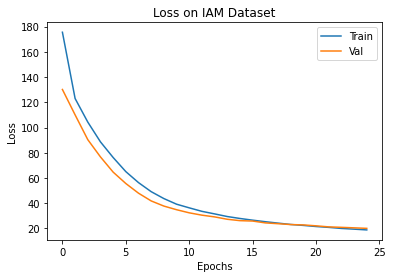

In [ ]:
plt.title('Loss on IAM Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(losses[0], label='Train')
plt.plot(losses[1], label='Val')
plt.legend()
plt.show()

## Test the Model Qualitatively and Quantitatively

Run through a few images on the validation set to see how our model is performing and then calculate the character and word error rates on the
validation set.

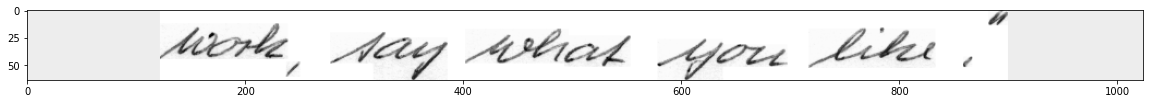

Predicted: tf.Tensor([b'worke, lay wehat won like,"'], shape=(1,), dtype=string)
Actual: tf.Tensor([b'work, say what you like."'], shape=(1,), dtype=string)


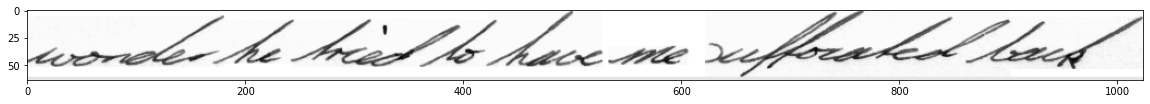

Predicted: tf.Tensor([b'woaete histo hae me stuadrd'], shape=(1,), dtype=string)
Actual: tf.Tensor([b'wonder he tried to have me suffocated back'], shape=(1,), dtype=string)


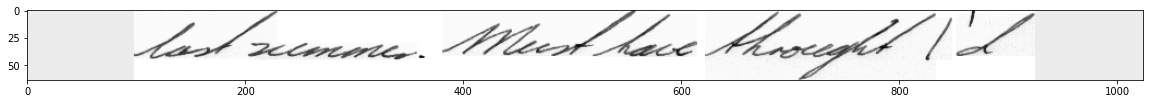

Predicted: tf.Tensor([b'baatsucmener. Hhest tace thougltI d'], shape=(1,), dtype=string)
Actual: tf.Tensor([b"last summer. Must have thought I'd"], shape=(1,), dtype=string)


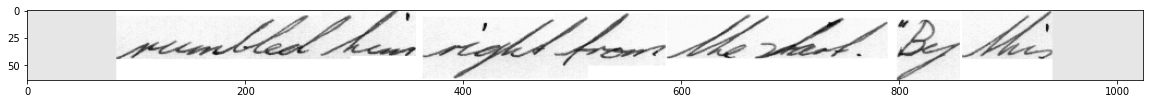

Predicted: tf.Tensor([b'reemlled hen sightthon heshe Dy this'], shape=(1,), dtype=string)
Actual: tf.Tensor([b'rumbled him right from the start." By this'], shape=(1,), dtype=string)


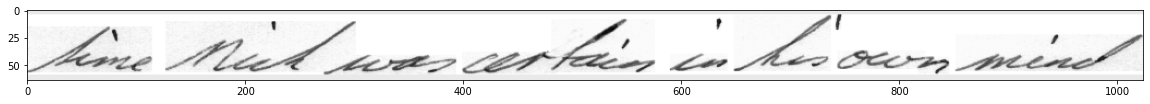

Predicted: tf.Tensor([b'hie widueertinci lsionmn'], shape=(1,), dtype=string)
Actual: tf.Tensor([b'time Nick was certain in his own mind'], shape=(1,), dtype=string)


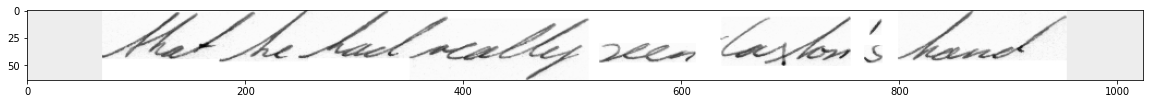

Predicted: tf.Tensor([b"thet he hadncall scen laston's hand"], shape=(1,), dtype=string)
Actual: tf.Tensor([b"that he had really seen Caxton's hand"], shape=(1,), dtype=string)


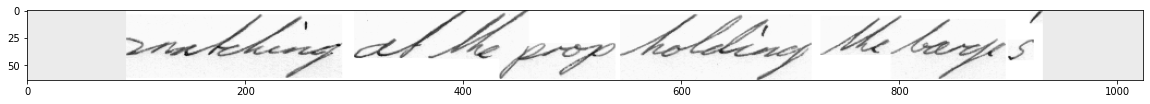

Predicted: tf.Tensor([b'snutling at he pap hobling the begus'], shape=(1,), dtype=string)
Actual: tf.Tensor([b"snatching at the prop holding the barge's"], shape=(1,), dtype=string)


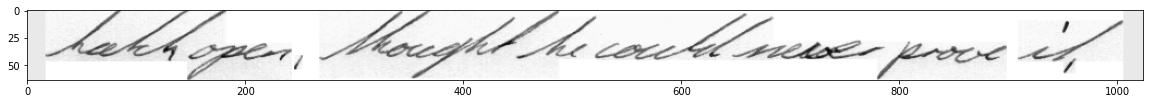

Predicted: tf.Tensor([b'aldsper, thouglkalmueyoee iit'], shape=(1,), dtype=string)
Actual: tf.Tensor([b'hatch open, though he could never prove it,'], shape=(1,), dtype=string)


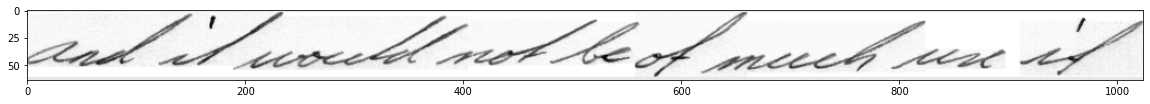

Predicted: tf.Tensor([b'anduoudrodomeedunii'], shape=(1,), dtype=string)
Actual: tf.Tensor([b'and it would not be of much use if'], shape=(1,), dtype=string)


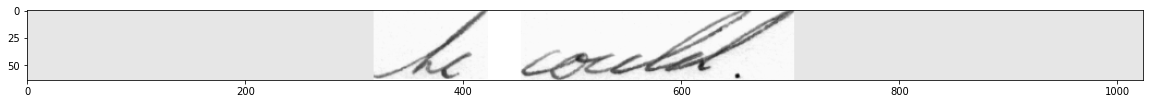

Predicted: tf.Tensor([b't coccl'], shape=(1,), dtype=string)
Actual: tf.Tensor([b'he could.'], shape=(1,), dtype=string)


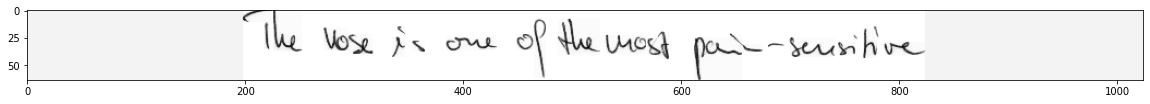

Predicted: tf.Tensor([b'The bose is one of the most pain-seusitive'], shape=(1,), dtype=string)
Actual: tf.Tensor([b'The nose is one of the most pain-sensitive'], shape=(1,), dtype=string)


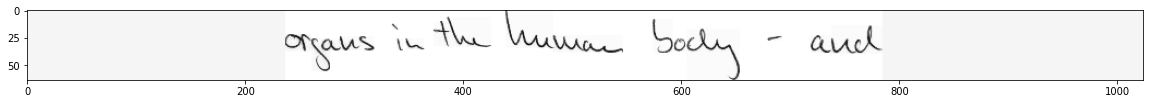

Predicted: tf.Tensor([b'orgus in the buman boly - and'], shape=(1,), dtype=string)
Actual: tf.Tensor([b'organs in the human body - and'], shape=(1,), dtype=string)


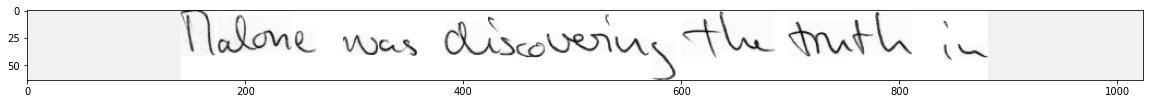

Predicted: tf.Tensor([b'Malone was disovering the thuth in'], shape=(1,), dtype=string)
Actual: tf.Tensor([b'Malone was discovering the truth in'], shape=(1,), dtype=string)


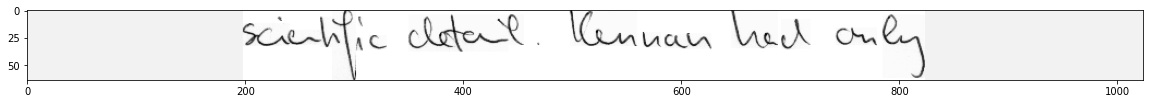

Predicted: tf.Tensor([b'scietific cdateil. lennan had only'], shape=(1,), dtype=string)
Actual: tf.Tensor([b'scientific detail. Kennan had only'], shape=(1,), dtype=string)


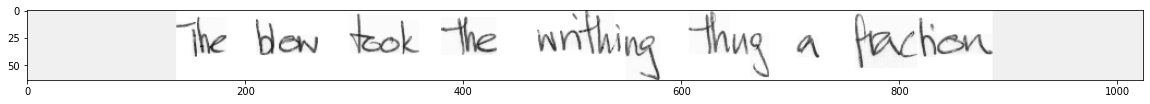

Predicted: tf.Tensor([b'the low took the withing thng a faction'], shape=(1,), dtype=string)
Actual: tf.Tensor([b'The blow took the writhing thug a fraction'], shape=(1,), dtype=string)


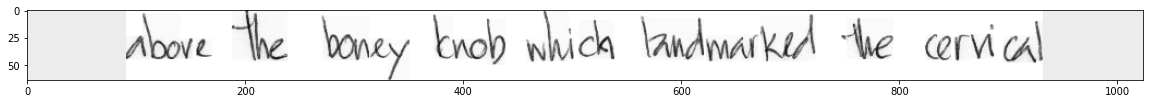

Predicted: tf.Tensor([b'abore the boney knok which landmarhed he cervicnl'], shape=(1,), dtype=string)
Actual: tf.Tensor([b'above the boney knob which landmarked the cervical'], shape=(1,), dtype=string)


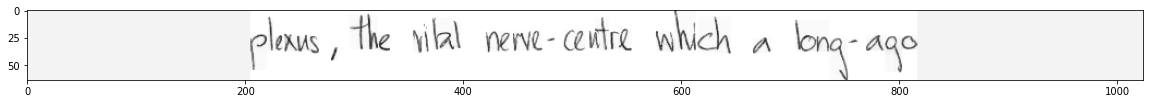

Predicted: tf.Tensor([b'plams, the wihl nene-centre which a lng-ago'], shape=(1,), dtype=string)
Actual: tf.Tensor([b'plexus, the vital nerve-centre which a long-ago'], shape=(1,), dtype=string)


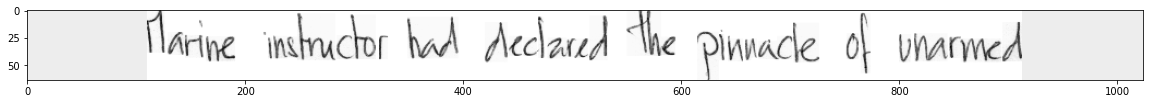

Predicted: tf.Tensor([b'Marine instmctor had sedared the pimade of unammed'], shape=(1,), dtype=string)
Actual: tf.Tensor([b'Marine instructor had declared the pinnacle of unarmed'], shape=(1,), dtype=string)


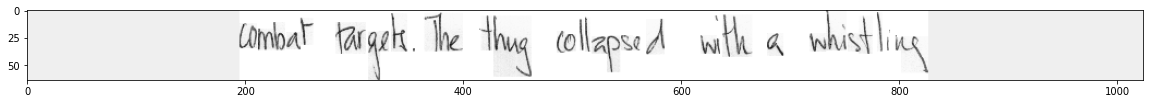

Predicted: tf.Tensor([b'uhat targetr. The thng olapad with a whistling'], shape=(1,), dtype=string)
Actual: tf.Tensor([b'combat targets. The thug collapsed with a whistling'], shape=(1,), dtype=string)


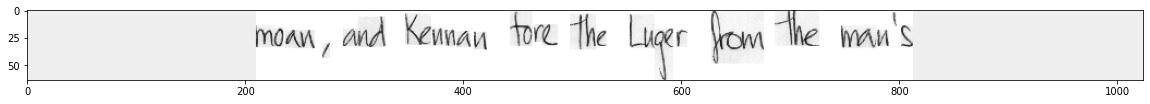

Predicted: tf.Tensor([b"mom, and heman tore the lger fom the man's"], shape=(1,), dtype=string)
Actual: tf.Tensor([b"moan, and Kennan tore the Luger from the man's"], shape=(1,), dtype=string)


In [ ]:
NUM_EXAMPLES = 20

test_dataset = dataset.skip(train_dataset_size).take(NUM_EXAMPLES).batch(1)

for image, label in test_dataset:
    # Make a prediction
    output = model(image)

    # Use best-path decoding
    prediction = tf.argmax(output, axis=2)

    # Display the image
    plt.figure(figsize=(20,20))
    plt.imshow(tf.transpose(tf.squeeze(image)), cmap='gray')
    plt.pause(.1)

    # Print the predicted/actual labels
    print('Predicted:', idxs_to_str_batch(prediction, idx2char, merge_repeated=True))
    print('Actual:', idxs_to_str_batch(label, idx2char, merge_repeated=False))

Quantitatively evaluate how the model did using the character and word
error rate metrics.

In [ ]:
metrics = ModelMetrics(model, test_dataset, idx2char)
character_error_rate, word_error_rate = metrics.get_error_rates()

print('Character Error Rate: {:.4f}%'.format(character_error_rate * 100))
print('Word Error Rate: {:.4f}%'.format(word_error_rate * 100))

Character Error Rate: 30.2507%
Word Error Rate: 70.2817%


## TF-Explain

Try to gain some sort of understanding of what the model is learning.

In [ ]:
import tf_explain as tfe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r 'drive/My Drive/iam_hwr_model' ./

Mounted at /content/drive


In [ ]:
!ls iam_hwr_model

checkpoint  run1.data-00000-of-00001  run1.index


In [ ]:
tf.keras.Model(input)

In [ ]:
model = Recognizer()
model.load_weights('iam_hwr_model/run1')

In [ ]:
char2idx = get_char2idx(DEFAULT_CHARS)
idx2char = get_idx2char(DEFAULT_CHARS)

dataset = get_encoded_dataset_from_csv('iam/labels.csv', char2idx, 128, (64, 1024))

for img, label in dataset.take(1):
    output = model(tf.expand_dims(img, 0))
    print('Prediction:',  idxs_to_str(tf.squeeze(tf.argmax(output, 2)), idx2char, merge_repeated=True))
    print('Actual:', idxs_to_str(tf.squeeze(label), idx2char, merge_repeated=False))

Prediction: tf.Tensor(b'f MOVE to stop Mr. Gaitskell from', shape=(), dtype=string)
Actual: tf.Tensor(b'A MOVE to stop Mr. Gaitskell from', shape=(), dtype=string)


In [ ]:
model(tf.keras.Input(shape=(1024, 64, 1), batch_size=1))
model.summary()

(1, 128, 2, 64)
Model: "flor_recognizer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Sequential)           (1, 512, 32, 16)          4928      
_________________________________________________________________
conv2 (Sequential)           (1, 512, 32, 32)          23392     
_________________________________________________________________
conv3 (Sequential)           (1, 256, 8, 40)           39480     
_________________________________________________________________
dropout1 (Dropout)           (1, 256, 8, 40)           0         
_________________________________________________________________
conv4 (Sequential)           (1, 256, 8, 48)           59280     
_________________________________________________________________
dropout2 (Dropout)           (1, 256, 8, 48)           0         
_________________________________________________________________
conv5 (Sequential)           (1, 12

In [ ]:
explainer = tfe.core

for img, label in dataset.take(1):
    output = model(tf.expand_dims(img, 0))
    print('Prediction:',  idxs_to_str(tf.squeeze(tf.argmax(output, 2)), idx2char, merge_repeated=True))
    print('Actual:', idxs_to_str(tf.squeeze(label), idx2char, merge_repeated=False))   

    data = ([tf.expand_dims(img, 0)], None)
    grid = explainer.explain(data, model, layers_name=['reshape'])
    plt.imshow(grid)
    plt.pause(0.01)

(1, 128, 2, 64)
Prediction: tf.Tensor(b'f MOVE to stop Mr. Gaitskell from', shape=(), dtype=string)
Actual: tf.Tensor(b'A MOVE to stop Mr. Gaitskell from', shape=(), dtype=string)


ValueError: ignored